# imports

In [8]:
#@title Imports and Notebook Utilities
import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import random
import h5py
import os
import piq
import ast
from IPython.display import Image, HTML, Markdown, clear_output
from tqdm import tqdm_notebook, tnrange

!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 Laptop GPU (UUID: GPU-6cf8054c-6c04-c256-2ebb-8137cfc2e798)


In [9]:
import torch
import torchvision.models as models
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch import nn
from IPython.display import clear_output, display, HTML
import h5py
from pathlib import Path


import sys
sys.path.append("C:/Users/GAI/Desktop/Scott/NCA_Research")


from core_utils.plotting import *
from core_utils.utils_image import *
from core_utils.viz_train import *
from E4_PI_NCA.utils.helper import *
from E4_PI_NCA.utils.Dataset import *
from E4_PI_NCA.utils.PI_Metric import ScaledPhysicsMetrics

torch.set_default_device('cuda')

# heliper

In [10]:
def normalize_to_01(x):
    x_min, x_max = x.amin(dim=(1,2,3), keepdim=True), x.amax(dim=(1,2,3), keepdim=True)
    return (x - x_min) / (x_max - x_min + 1e-8)

def sperate_base_channels(x, base_channel_count=6):
    """將基礎通道與其他通道分離"""
    base_channels = x[:, :base_channel_count, :, :]
    other_channels = x[:, base_channel_count:, :, :]
    return base_channels, other_channels

In [11]:
def to_device(data, device):
    if isinstance(data, torch.Tensor):
        return data.to(device)
    elif isinstance(data, dict):
        return {k: to_device(v, device) for k, v in data.items()}
    elif isinstance(data, list):
        return [to_device(v, device) for v in data]
    elif isinstance(data, tuple):
        return tuple(to_device(v, device) for v in data)
    else:
        return data  # 非 tensor 原樣返回

# physics loss

In [12]:

# 索引 (Indices)
IDX_U_COMPONENTS = 6  # uped = < u >
IDX_V_COMPONENTS = 7  # vped = < v >
IDX_U_MAGNITUDE = 8   # Uped = < sqrt(u^2+v^2) >
IDX_TKE = 9           # TKEped
IDX_T_UW = 10         # Tuwped
IDX_DWDZ = 11    # dW/dz (z-gradient), 來自 "散度=0" 的推斷


class PhysicsLoss(nn.Module):
    """
    計算基於物理屬性的可微分損失 (PINN Loss)。

    V3 - L_u_bound:
    - 正確地將速度一致性作為單向不等式約束：
      <sqrt(u^2+v^2)> (U_pred) >= sqrt(<u>^2 + <v>^2) (reconstructed_mean_mag)
    - 懲罰 L_u_bound = relu(reconstructed_mean_mag - U_pred)
    
    V4 - L_continuity:
    - 增加了不可壓縮流體的連續方程式 (質量守恆) 損失。
    - L_continuity = mean( (dU/dx + dV/dy + dW/dz)^2 )
    """

    def __init__(self, alpha: float = 2.25, weights: dict = None):
        """
        初始化 PhysicsLoss。

        :param alpha: T_uw 邊界懲罰的縮放因子 (alpha * TKE)
        :param weights: 一個字典，用於覆蓋默認的損失權重。
        """
        super().__init__()
        self.alpha = alpha

        # 設置默認權重
        default_weights = {
            "L_k_neg": 1.0,      # TKE 負值懲罰
            "L_flux": 1.0,       # 通量超界懲罰
            "L_u_bound": 1.0,    # 速度邊界不等式懲罰
            "L_continuity": 1.0  # 連續方程式 (質量守恆) 懲罰
        }

        if weights is None:
            self.weights = default_weights
        else:
            # 使用傳入的 weights 更新默認值
            self.weights = default_weights
            self.weights.update(weights)

        print("PhysicsLoss initialized (V4 - L_continuity added)")
        print(f"Loss Weights: {self.weights}")

    def forward(self, pred: torch.Tensor, dydx: List[Tuple[float, float]] = None) -> Tuple[torch.Tensor, dict]:
        """
        計算總的物理損失。

        :param pred: 模型的預測輸出 (B, C, H, W)
        :param dydx: 包含 (H_orig, W_orig) 的列表，長度為 B。
                     代表每個 batch item 的原始物理尺寸 (單位: m)。
        :return: (total_loss, loss_dict)
        """

        # --- 1. 提取所需通道 ---
        # 這些是 (B, H, W)
        u_pred = pred[:, IDX_U_COMPONENTS]
        v_pred = pred[:, IDX_V_COMPONENTS]
        U_pred = pred[:, IDX_U_MAGNITUDE]
        TKE_pred = pred[:, IDX_TKE]
        T_uw_pred = pred[:, IDX_T_UW]
        # dW/dz 是由 NN 直接預測的
        dW_dz_pred = pred[:, IDX_DWDZ]

        B, C, H_nn, W_nn = pred.shape

        loss_dict = {}
        total_loss = torch.tensor(0.0, device=pred.device)

        # --- 2. L_k_neg (TKE 負值懲罰) ---
        if self.weights.get("L_k_neg", 0.0) > 0:
            L_k_neg = torch.mean(torch.relu(-TKE_pred))
            loss_dict["L_k_neg"] = L_k_neg
            total_loss += self.weights["L_k_neg"] * L_k_neg

        # --- 3. L_flux (通量超界懲罰) ---
        if self.weights.get("L_flux", 0.0) > 0:
            TKE_non_neg = torch.relu(TKE_pred)
            flux_bound_error = torch.abs(T_uw_pred) - (self.alpha * TKE_non_neg)
            L_flux = torch.mean(torch.relu(flux_bound_error))
            loss_dict["L_flux"] = L_flux
            total_loss += self.weights["L_flux"] * L_flux

        # --- 4. L_u_bound (速度邊界不等式) ---
        if self.weights.get("L_u_bound", 0.0) > 0:
            # 計算平均速度的速率: sqrt(<u>^2 + <v>^2)
            reconstructed_mean_mag = torch.sqrt(u_pred**2 + v_pred**2 + 1e-8)

            # 物理定律是: U_pred >= reconstructed_mean_mag
            # 違規 (Violation) 是當: reconstructed_mean_mag > U_pred
            violation = reconstructed_mean_mag - U_pred

            # 僅懲罰違規的部分 (單向約束)
            L_u_bound = torch.mean(torch.relu(violation))
            loss_dict["L_u_bound"] = L_u_bound
            total_loss += self.weights["L_u_bound"] * L_u_bound

        # --- 5. L_continuity (不可壓縮質量守恆) ---
        if self.weights.get("L_continuity", 0.0) > 0:
            if dydx is None:
                # 如果沒有提供 dydx，我們無法計算物理梯度，必須跳過
                L_continuity = torch.tensor(0.0, device=pred.device)
                if self.training: # 只在訓練時打印警告，避免推理時刷屏
                    print("Warning: 'dydx' is None. Skipping L_continuity calculation.")
            else:
                # 這是最關鍵的一步：
                # 我們的梯度 dU/dx 需要是 *物理* 梯度，而不是 *像素* 梯度。
                # dU/dx = (dU / d(pixel_W)) * (d(pixel_W) / dx)
                # (d(pixel_W) / dx) = W_nn / W_orig = 1 / dx_spacing
                
                # 1. 獲取原始物理尺寸 (B,)
                H_orig_batch = torch.tensor([item[0] for item in dydx], device=pred.device, dtype=pred.dtype)
                W_orig_batch = torch.tensor([item[1] for item in dydx], device=pred.device, dtype=pred.dtype)

                # 2. 計算每個像素的物理間距 (spacing) (B,)
                dy_spacing = H_orig_batch / H_nn
                dx_spacing = W_orig_batch / W_nn

                # 3. 將 spacing 擴展 (broadcast) 到 (B, 1, 1) 以便進行元素除法
                dy_b = dy_spacing.view(B, 1, 1)
                dx_b = dx_spacing.view(B, 1, 1)

                # 4. 計算 *像素* 梯度 (Pixel-space gradients)
                # dim=(-2, -1) 對應 (H, W)
                grad_u_y_px, grad_u_x_px = torch.gradient(u_pred, dim=(-2, -1))
                grad_v_y_px, grad_v_x_px = torch.gradient(v_pred, dim=(-2, -1))

                # 5. 轉換為 *物理* 梯度 (Physical-space gradients)
                # dU/dx = (dU / d_pixel_W) / (dx / d_pixel_W) = grad_u_x_px / dx_b
                dU_dx_pred = grad_u_x_px / dx_b
                
                # dV/dy = (dV / d_pixel_H) / (dy / d_pixel_H) = grad_v_y_px / dy_b
                dV_dy_pred = grad_v_y_px / dy_b

                # 6. 計算物理殘差 (Residual)
                # R = dU/dx + dV/dy + dW/dz
                # dW/dz 是 NN 直接預測的，所以我們直接使用
                physics_residual = dU_dx_pred + dV_dy_pred + dW_dz_pred

                # 7. 計算 Loss (Mean Squared Error of the residual)
                L_continuity = torch.mean(physics_residual**2)
            
            loss_dict["L_continuity"] = L_continuity
            total_loss += self.weights["L_continuity"] * L_continuity

        # --- 總損失 ---
        loss_dict["L_physics_total"] = total_loss
        return total_loss, loss_dict

# NCA model

In [13]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
IDX_GEO_MASK = 2
def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = F.pad(y, [1, 1, 1, 1], 'circular')
  y = F.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96):
    super().__init__()
    self.chn = chn
    self.w1 = nn.Conv2d(chn*4, hidden_n, 1)
    self.w2 = nn.Conv2d(hidden_n, chn, 1, bias=False)
    self.w2.weight.data.zero_()

  def forward(self, x, update_rate=0.5):
    y = perception(x)
    y = self.w2(torch.relu(self.w1(y)))
    b, c, h, w = y.shape
    udpate_mask = x[:,IDX_GEO_MASK:IDX_GEO_MASK+1]
    no_change = x[:, :6, :, :]
    updated = x + y * x[:, 2:3, :, :]
    return torch.cat([no_change, updated[:, 6:, :, :]], dim=1)

  def seed(self, n, sz=128):
    return torch.zeros(n, self.chn, sz, sz)

def to_rgb(x):
  return x[...,:3,:,:]+0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 5856


# setup training

In [14]:
# ============================================
# 裝置設定
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# 數據載入
# ============================================
DATASET_IMG_SIZE = (128,128)
dataset_dir = "../dataset_h5/train"

# 讀取全部案例 → 轉為 [B, C, H, W]
loaded_dataset, dataset_city_size = load_all_cases_to_BCHW(
    dataset_dir, 
    target_size=DATASET_IMG_SIZE
)

# ============================================
# 模型與訓練超參數
# ============================================
CHANNEL_C      = 24     # CA 狀態通道數
LEARNING_RATE  = 1e-3
POOL_SIZE      = 256    # 資料池大小 (replay-like)
TOTAL_EPOCH    = 5000

# ============================================
# 初始化模型、優化器、學習率排程
# ============================================
pi_module = CA(chn=CHANNEL_C).to(device)

opt = torch.optim.Adam(pi_module.parameters(), LEARNING_RATE, capturable=True)

lr_sched = torch.optim.lr_scheduler.MultiStepLR(
    opt, 
    milestones=[1000, 2000], 
    gamma=0.3
)

loss_log    = []
metrics_log = []

# 啟用 Gradient Checkpoint？(省顯存, 慢約10~20%)
gradient_checkpoints = False

# ============================================
# 損失函數設定
# ============================================
# --- Physics-informed Loss (PINN)
pinn_loss_fn = PhysicsLoss(
    alpha=2.25,
    weights={
        "L_k_neg": 1.0,       # TKE < 0 懲罰
        "L_flux": 1.0,        # 邊界通量約束
        "L_u_bound": 1.0,     # 速度邊界條件
        "L_continuity": 1.0   # 質量守恆 (∇·u = 0)
    }
).to(device)

# --- Data Loss (MSE)
mse_loss_fn = nn.MSELoss().to(device)

# --- Loss 權重 (需調參)
LAMBDA_MSE      = 1.0   # 對齊地面真值
LAMBDA_PINN     = 10.0  # 遵守物理
LAMBDA_OVERFLOW = 0.1   # 平衡數值穩定


PhysicsLoss initialized (V4 - L_continuity added)
Loss Weights: {'L_k_neg': 1.0, 'L_flux': 1.0, 'L_u_bound': 1.0, 'L_continuity': 1.0}


In [15]:
# ============================================
# 載入 Init 模組 (凍結版本)
# ============================================

# 建立與訓練時相同架構
init_module = CA(chn=CHANNEL_C)

# 模型檢查點路徑
CHECKPOINT_PATH = r"..\outputs\E4-7.1_Init-NCA_20251102-153402/ca_model_step_5000.pth"

# 載入權重
try:
    checkpoint = torch.load(CHECKPOINT_PATH)
    init_module.load_state_dict(checkpoint["model_state_dict"])
    print(f"[Init] 已載入: {CHECKPOINT_PATH} (epoch {checkpoint['epoch']})")

except FileNotFoundError:
    print(f"[Init] ❌ 找不到檔案: {CHECKPOINT_PATH}")
except Exception as e:
    print(f"[Init] ⚠️ 載入錯誤: {e}")

# --------------------------------------------
# 冻結 Init 模組：只當固定前處理器，不參與訓練
# --------------------------------------------
init_module.eval()               # 關閉 Dropout/BN 更新
for p in init_module.parameters():
    p.requires_grad = False      # 停止梯度追蹤

# 移動到 GPU/CPU
init_module = init_module.to(device)

print("[Init] 模組已凍結 (Frozen)")


[Init] 已載入: ..\outputs\E4-7.1_Init-NCA_20251102-153402/ca_model_step_5000.pth (epoch 5000)
[Init] 模組已凍結 (Frozen)


# training loop

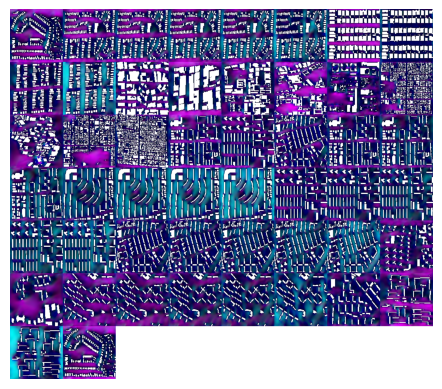

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99383545..1.0].


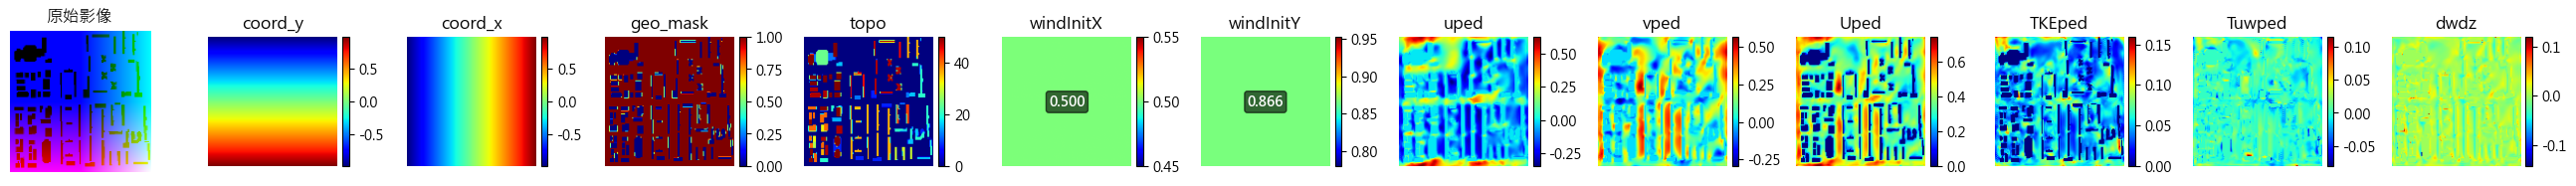

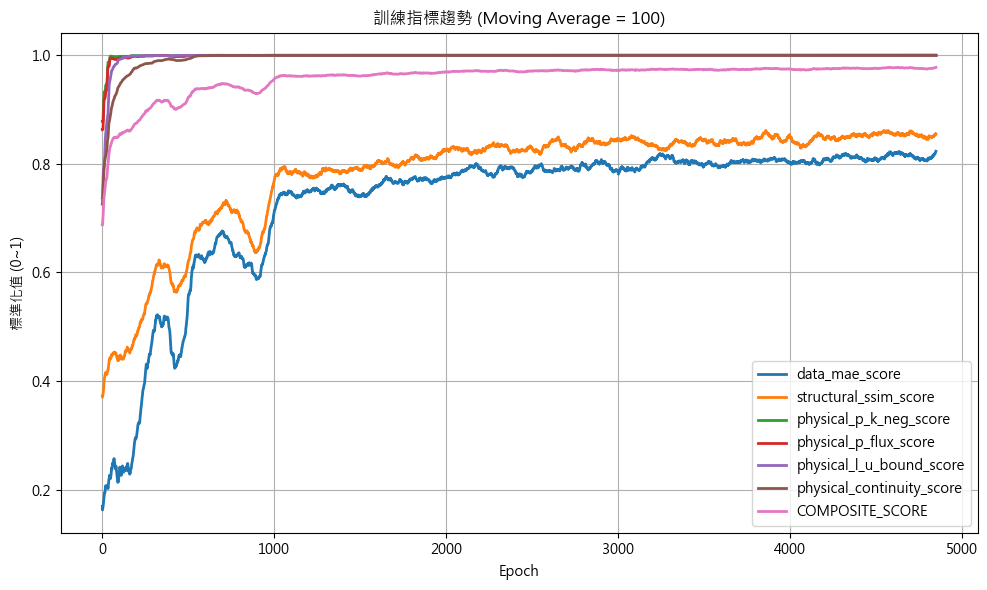

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


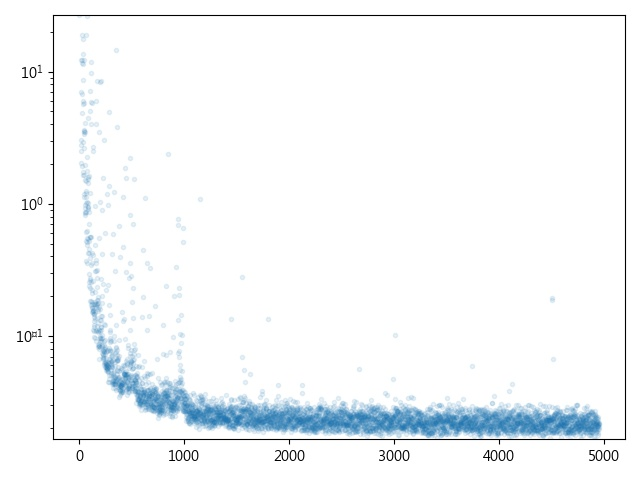

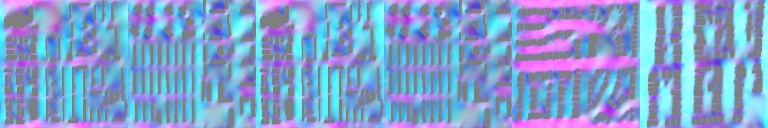

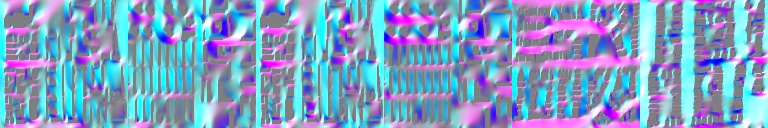

💾 已儲存新檢查點：..\outputs\E4-7.2_PI-NCA_20251102-162009/ca_model_step_4950.pth
✅ 已刪除舊檢查點：..\outputs\E4-7.2_PI-NCA_20251102-162009\ca_model_step_4800.pth
🗑️ 目前保留最新的 3 個檢查點。
💾 已儲存新檢查點：..\outputs\E4-7.2_PI-NCA_20251102-162009/ca_model_step_5000.pth
✅ 已刪除舊檢查點：..\outputs\E4-7.2_PI-NCA_20251102-162009\ca_model_step_4850.pth
🗑️ 目前保留最新的 3 個檢查點。


In [16]:
import time
# --- 模型儲存設定 (在訓練迴圈外定義) ---
model_save_dir = get_output_path()  # 模型儲存的目錄路徑
model_name_format = "ca_model_step_{}.pth" # 模型檔案名稱的格式，包含當前步驟 i



for i in range(TOTAL_EPOCH):

    # ----------------- Pool update -----------------
    t0 = time.time()
    if i % 500 == 0:
        x_pool, y_pool, pool_city_size = create_pool(
            loaded_dataset, dataset_city_size,
            pool_size=POOL_SIZE, channel_c=CHANNEL_C
        )
        x_pool, y_pool = x_pool.to(device), y_pool.to(device)
        metric_calculator = ScaledPhysicsMetrics(y_pool, pool_city_size)
    # print(f"[{i}] pool_update: {time.time() - t0:.4f}s")

    # ----------------- Sample batch -----------------
    t0 = time.time()
    with torch.no_grad():
        batch_idx = np.random.choice(len(x_pool), 6, replace=False)
        batch_city_size = [pool_city_size[j] for j in batch_idx.tolist()]

        x = x_pool[batch_idx].clone()
        y = y_pool[batch_idx]

        if i % 8 == 0:
            x[:1, 6:, :, :] = 0
    # print(f"[{i}] sample_batch: {time.time() - t0:.4f}s")

    # ----------------- Forward -----------------
    t0 = time.time()
    step_n = np.random.randint(32, 96)
    if not gradient_checkpoints:
        x_initial = x.clone()
        for _ in range(step_n):
            with torch.no_grad():
                x = init_module(x)
            x = pi_module(x)
    else:
        x.requires_grad = True
        module_list = [init_module]*step_n + [pi_module]
        x = torch.utils.checkpoint.checkpoint_sequential(module_list, 16, x)
    # print(f"[{i}] forward: {time.time() - t0:.4f}s")

    # ----------------- Loss -----------------
    t0 = time.time()
    overflow_loss = (x[:, 6:11] - x[:, 6:11].clamp(-1, 1)).abs().sum()
    loss_mse = mse_loss_fn(x[:, 6:11], y[:, 6:11])
    loss_pinn, pinn_loss_dict = pinn_loss_fn(x, batch_city_size)
    loss = (
        LAMBDA_MSE * loss_mse +
        LAMBDA_PINN * loss_pinn +
        LAMBDA_OVERFLOW * overflow_loss
    )
    # print(f"[{i}] loss_calc: {time.time() - t0:.4f}s")

    # ----------------- Backward -----------------
    t0 = time.time()
    opt.zero_grad()
    loss.backward()
    with torch.no_grad():
        for p in pi_module.parameters():
            if p.grad is not None:
                p.grad /= (p.grad.norm() + 1e-8)
        opt.step()
        lr_sched.step()
        x_pool[batch_idx] = x.detach()
    # print(f"[{i}] backward: {time.time() - t0:.4f}s")

    # ----------------- Metrics -----------------
    t0 = time.time()
    loss_log.append(loss.item())
    with torch.no_grad():
        metrics_result = metric_calculator(x, y, batch_city_size)
        metrics_log.append(to_device(metrics_result, "cpu"))
    # print(f"[{i}] metrics: {time.time() - t0:.4f}s")

    # ----------------- Visual & save -----------------
    t0 = time.time()
    if i % 50 == 0:
        clear_output(wait=True)
        viz_pool(x_pool, step_i=i)
        plt_HWC_split_channels(to_HWC(x[0, :12]))
        metrics_log = to_device(metrics_log, "cpu")
        plt_metrics_dict(metrics_log, window=100)
        pl.plot(loss_log, '.', alpha=0.1)
        pl.yscale('log')
        pl.ylim(min(loss_log), loss_log[0])
        pl.tight_layout()
        imshow(grab_plot(), id='log')
        imshow(np.hstack(to_rgb(x[:,6:,:,:]).permute(0,2,3,1).cpu().detach().numpy()), id='batch')
        imshow(np.hstack(to_rgb(y[:,6:,:,:]).permute(0,2,3,1).cpu().detach().numpy()), id='target')
        save_checkpoint(pi_module, opt, i, f"{model_save_dir}/{model_name_format.format(i)}")
    # print(f"[{i}] viz: {time.time() - t0:.4f}s")
save_checkpoint(pi_module, opt, TOTAL_EPOCH, f"{model_save_dir}/{model_name_format.format(TOTAL_EPOCH)}")


# output video

In [17]:
test_x_pool, test_y_pool = create_pool(loaded_dataset, pool_size=256, channel_c=24)
test_x_pool, test_y_pool = test_x_pool.to(device), test_y_pool.to(device)
metric_calculator = ScaledPhysicsMetrics(test_y_pool)

with VideoWriter() as vid, torch.no_grad():
  batch_idx = np.random.choice(len(test_x_pool), 4, replace=False)
  test_x = test_x_pool[batch_idx].clone()  # clone 避免 in-place 污染
  test_y = test_y_pool[batch_idx]
  plt_HWC_split_channels(to_HWC(test_x[0,:11]))

  for k in tnrange(300, leave=False):
    step_n = min(2**(k//30), 8)
    for i in range(step_n):
      test_x[:] = ca(test_x)
    img = to_rgb(test_x[0,6:]).permute(1, 2, 0).cpu()
    vid.add(zoom(img, 2))

TypeError: create_pool() missing 1 required positional argument: 'city_size'